In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange

from experiments.trading_model import *
from experiments.experiment_utils import *
from cvx.covariance.ewma import ewma_mean, ewma_cov, iterated_ewma
from cvx.covariance.covariance_combination import CovarianceCombination
sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

# Import data

In [2]:
returns = pd.read_csv('../data/SP500_top25_adjusted.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# Covariance predictors

In [3]:
### Parameters
rw_memory = 250
ewma_halflife=125
iewma_pair = (63,125)
cm_iewma_pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)]

In [4]:
# Rolling window 
rw = rolling_window(returns, rw_memory) 

In [5]:
# EWMA
ewma = dict(ewma_cov(returns, halflife=ewma_halflife))

In [6]:
# IEWMA  
iewma = list(iterated_ewma(returns, vola_halflife=iewma_pair[0], cov_halflife=iewma_pair[1]))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

Next we import the precomputed MGARCH predictors (computed using the rmgarch
package in R). We used the first 250 days for training. Hence the first
predictors is given at day 250, and predicts the covariance matrix for day 251.
(Python uses zero-based indexing, so the first predictor will have time index 249.)

In [7]:
# MGARCH precomputed in R due to computational complexity
# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov = pd.read_csv("../mgarch_predictors_from_R/stocks/mgarch_stocks_adj.csv", index_col=None)
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns.shape[1]) / 10000

# Remove first year since it was used for training
times = returns.index[249:] 
mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=returns.columns, columns=returns.columns) for t in range(Sigmas.shape[0])}

In [8]:
# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(CovarianceCombination(Sigmas=Sigmas, returns=returns).solve_window(window=10, verbose=True))

cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}

100%|██████████| 3138/3138 [00:44<00:00, 71.16it/s] 


In [9]:
# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

# Define end and start dates for backtests

In [10]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2011-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [11]:
names = ["RW", "EWMA", "IEWMA", "MGARCH", "CM-IEWMA", "PRESCIENT"]

predictors_temp = [rw, ewma, iewma, mgarch, cm_iewma, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# CM-IEWMA component weights

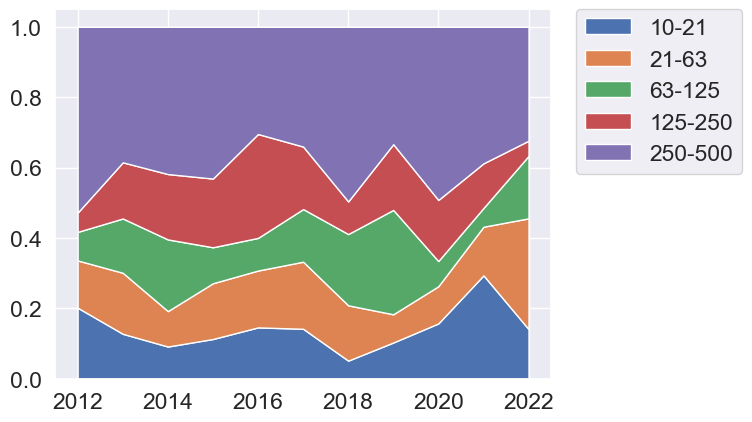

In [37]:
quarterly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

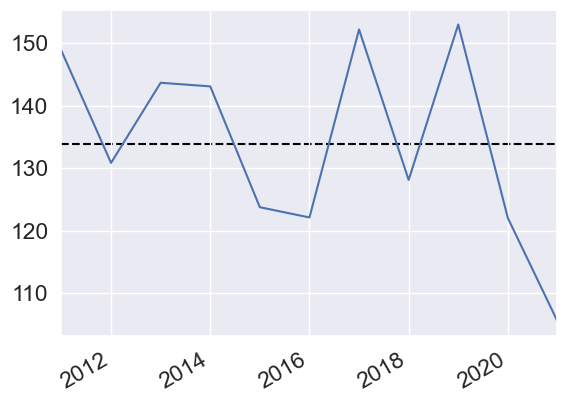

In [38]:
halflifes_vola = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
(quarterly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.gcf().autofmt_xdate()

# Log likelihoods

In [14]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

Computing RW-250 log-likelihood...
Computing EWMA-125 log-likelihood...
Computing IEWMA-63-125 log-likelihood...
Computing MGARCH log-likelihood...
Computing CM-IEWMA log-likelihood...
Computing PRESCIENT log-likelihood...


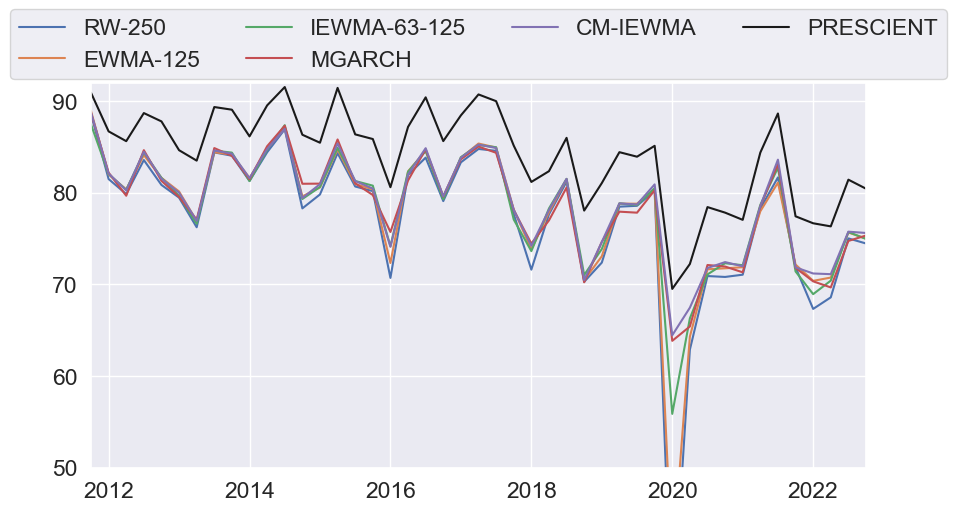

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(50,92);

# Regrets

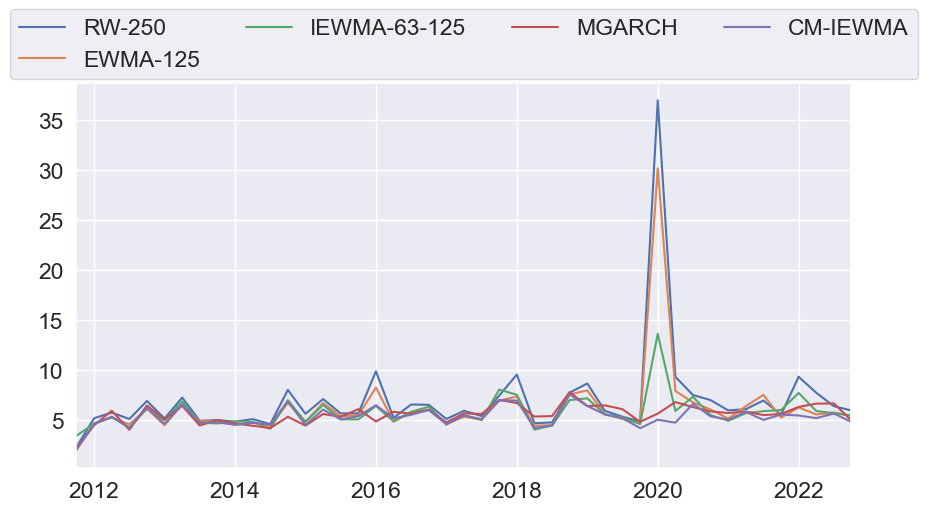

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);


### Compare CM-IEWMA with MGARCH

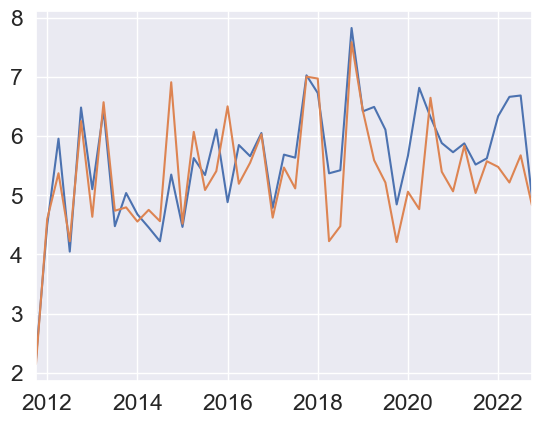

In [17]:
regret_mgarch = regrets["MGARCH"].resample("Q").mean()
regret_cm_iewma = regrets["CM-IEWMA"].resample("Q").mean()

regret_mgarch.plot(label="MGARCH")
regret_cm_iewma.plot(label="CM-IEWMA");
# plt.legend();

In [18]:
cm_iewma_advantage = (regret_cm_iewma - regret_mgarch < 0).mean()
print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

CM-IEWMA is better than MGARCH 71% of the time


### Regret CDF plots

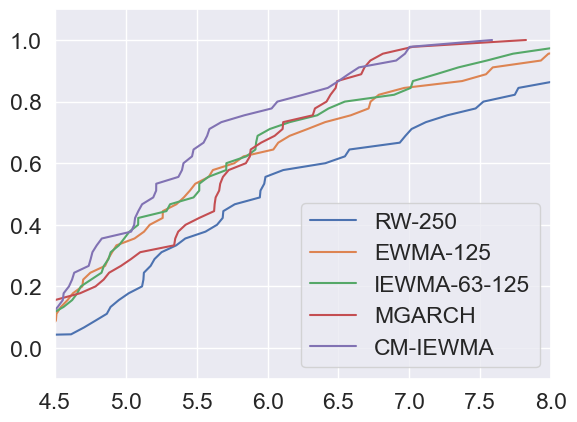

In [19]:
for name in log_likelihoods:
    if name != "PRESCIENT":
        data = regrets[name].resample("Q").mean().values
        x, y = ecdf(data)
        plt.plot(x, y, label=name)
plt.xlim(4.5,8)
plt.ylim(-0.1,1.1)
plt.legend();

### Regret metrics

In [20]:
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        regret = regrets[name].resample("Q").mean()
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        print("{} & {} & {} \\\\".format(metrics[0], metrics[1], metrics[2]))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   RW-250 & 7.0 & 4.8 & 37.0 \\
   EWMA-125 & 6.2 & 3.8 & 30.2 \\
   IEWMA-63-125 & 5.8 & 1.6 & 13.6 \\
   MGARCH & 5.6 & 1.0 & 7.8 \\
   CM-IEWMA & 5.3 & 1.0 & 7.6 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


# Portfolio optimization

In [21]:
from experiments.portfolio_backtests import *

# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}
sigma_tar = 0.1
excess = True

### Equally weighted

In [22]:
traders_eq_w = EqWeighted(returns, predictors, names, start_date, end_date).backtest()

100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


In [23]:
create_table(traders_eq_w, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW-250 & 6.8\% & 10.6\% & 0.6 & 23\% \\
   EWMA-125 & 6.4\% & 10.0\% & 0.6 & 21\% \\
   IEWMA-63-125 & 6.7\% & 10.1\% & 0.7 & 20\% \\
   MGARCH & 7.2\% & 9.4\% & 0.8 & 15\% \\
   CM-IEWMA & 6.8\% & 9.6\% & 0.7 & 17\% \\
   \hline
   PRESCIENT & 12.8\% & 9.9\% & 1.3 & 10\% \\
   \bottomrule
\end{tabular}


### Minimum risk

In [39]:
traders_min_risk = MinRisk(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 6/6 [02:11<00:00, 21.97s/it]


In [25]:
create_table(traders_min_risk, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW-250 & 9.7\% & 12.0\% & 0.8 & 23\% \\
   EWMA-125 & 8.9\% & 11.1\% & 0.8 & 20\% \\
   IEWMA-63-125 & 9.7\% & 11.3\% & 0.9 & 19\% \\
   MGARCH & 11.3\% & 12.3\% & 0.9 & 18\% \\
   CM-IEWMA & 9.1\% & 11.0\% & 0.8 & 15\% \\
   \hline
   PRESCIENT & 15.6\% & 10.0\% & 1.6 & 10\% \\
   \bottomrule
\end{tabular}


### Maximum diversification 

In [26]:
traders_max_diverse = MaxDiverse(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 6/6 [00:49<00:00,  8.17s/it]


In [27]:
create_table(traders_max_diverse, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW-250 & 8.4\% & 11.2\% & 0.8 & 22\% \\
   EWMA-125 & 7.9\% & 10.4\% & 0.8 & 21\% \\
   IEWMA-63-125 & 8.2\% & 10.4\% & 0.8 & 20\% \\
   MGARCH & 10.0\% & 9.8\% & 1.0 & 15\% \\
   CM-IEWMA & 8.8\% & 10.0\% & 0.9 & 16\% \\
   \hline
   PRESCIENT & 13.5\% & 9.9\% & 1.4 & 11\% \\
   \bottomrule
\end{tabular}


### Risk parity 

In [28]:
traders_risk_par = RiskParity(returns, predictors, names, start_date, end_date).backtest()

100%|██████████| 6/6 [00:52<00:00,  8.77s/it]


In [29]:
create_table(traders_risk_par, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW-250 & 7.4\% & 10.8\% & 0.7 & 22\% \\
   EWMA-125 & 6.8\% & 10.1\% & 0.7 & 21\% \\
   IEWMA-63-125 & 7.2\% & 10.2\% & 0.7 & 20\% \\
   MGARCH & 7.9\% & 9.7\% & 0.8 & 15\% \\
   CM-IEWMA & 7.4\% & 9.7\% & 0.8 & 16\% \\
   \hline
   PRESCIENT & 14.3\% & 9.9\% & 1.5 & 9\% \\
   \bottomrule
\end{tabular}


### Mean variance

In [30]:
r_hat_ewma = pd.DataFrame(dict(ewma_mean(returns, halflife=63))).T
mean_predictors = [r_hat_ewma for name in names]

traders_mean_var = MeanVariance(returns, predictors, names, mean_predictors=mean_predictors, start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

100%|██████████| 6/6 [01:22<00:00, 13.72s/it]


In [31]:
create_table(traders_mean_var, None, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW-250 & 2.9\% & 11.7\% & 0.2 & 27\% \\
   EWMA-125 & 2.6\% & 11.2\% & 0.2 & 25\% \\
   IEWMA-63-125 & 3.2\% & 10.9\% & 0.3 & 23\% \\
   MGARCH & 2.3\% & 11.1\% & 0.2 & 21\% \\
   CM-IEWMA & 3.5\% & 10.9\% & 0.3 & 19\% \\
   \hline
   PRESCIENT & 5.6\% & 9.3\% & 0.6 & 16\% \\
   \bottomrule
\end{tabular}
